# Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, nbinom
from scipy.interpolate import CubicSpline
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, List

# Configuration pour la reproductibilité
np.random.seed(42)

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Paramètres du modèle VS²EI² de malaria

In [2]:
@dataclass
class MalariaParameters:
    """
    Paramètres du modèle VS²EI² de malaria.
    Tous les paramètres sont tirés de la Table 3 de l'article.
    """
    # Taux de transition entre compartiments (en année^-1)
    mu_I1_S2: float = 39.021      # Taux I₁ → S₂ (acquisition immunité partielle)
    mu_S2_S1: float = 0.334       # Taux S₂ → S₁ (perte immunité)
    mu_E_I1: float = 8.902        # Taux E → I₁ (fin période latence)
    mu_I1_I2: float = 5.511       # Taux I₁ → I₂ (infection asymptomatique)
    mu_I2_S2: float = 0.035       # Taux I₂ → S₂ (guérison partielle)
    mu_I1_S1: float = 6.563       # Taux I₁ → S₁ (guérison complète)
    
    # Paramètres de saisonnalité (coefficients des B-splines)
    n_s: int = 6                  # Nombre de splines
    beta_splines: np.ndarray = None  # Sera initialisé dans __post_init__
    
    # Paramètres du délai (développement du parasite dans le moustique)
    k: int = 2                    # Paramètre de forme (loi Gamma)
    tau: float = 0.030            # Délai moyen (en années)
    
    # Bruit de processus et d'observation
    sigma: float = 0.243          # Écart-type du bruit de processus (année^1/2)
    psi: float = 0.395            # Paramètre de dispersion (observation)
    
    # Paramètres de transmission
    rho: float = 0.015            # Fraction de cas reportés
    q: float = 9.424e-4           # Infectivité relative des asymptomatiques
    beta_bar: float = 1.0         # Constante dimensionnelle (année^-1)
    beta_climate: float = 0.512   # Coefficient de la covariate climatique
    
    # Conditions initiales (fractions de population)
    S1_0: float = 0.138
    S2_0: float = 0.775
    E_0: float = 0.004
    I1_0: float = 0.002
    I2_0: float = 0.080
    lambda1_0: float = 0.0171     # Force d'infection courante (×10)
    lambda2_0: float = 0.0061     # Force d'infection latente (×10)
    
    # Autres paramètres
    c: float = 0.010              # Coefficient de réinfection
    u: float = 5.0/12.0           # Fenêtre pluie (5 mois en années)
    v: float = 200.0              # Seuil de pluie intégrée (mm)
    delta: float = 1.0/50.0       # Taux de mortalité naturelle (1/espérance de vie)
    Delta: float = 1.0/365.0      # Pas de temps (1 jour en années)
    
    def __post_init__(self):
        """Initialise les coefficients de splines après la création."""
        if self.beta_splines is None:
            self.beta_splines = np.array([1.201, 2.088, 3.866, 2.808, 5.996, 5.333])

# Instanciation des paramètres
params = MalariaParameters()

print("Paramètres du modèle chargés:")
print(f"  - Nombre de compartiments: 5 (S₁, S₂, E, I₁, I₂)")
print(f"  - Taux de transition moyens: {np.mean([params.mu_E_I1, params.mu_I1_I2]):.2f} an⁻¹")
print(f"  - Délai moyen moustique: {params.tau*365:.1f} jours")
print(f"  - Pas de temps: {params.Delta*365:.0f} jour")

Paramètres du modèle chargés:
  - Nombre de compartiments: 5 (S₁, S₂, E, I₁, I₂)
  - Taux de transition moyens: 7.21 an⁻¹
  - Délai moyen moustique: 10.9 jours
  - Pas de temps: 1 jour


### Équations d'état

In [3]:
@dataclass
class MalariaState:
    """
    État complet du système à un instant t.
    Représente les 7 variables d'état du modèle VS²EI².
    """
    # Compartiments humains (fractions de population)
    S1: float  # susceptible
    S2: float  # partially protected
    E: float   # exposed and carrying a latent infection
    I1: float  # infected and infectious to uninfected mosquitoes
    I2: float  # carrying asymptomatic infection and infectious to uninfected mosquitoes with a reduced level of infectivity than class I1
    
    # Forces d'infection retardées (pour le délai moustique) # cette partie faut que je la comprenne 
    lambda1: float  # λ₁(t) - première étape du délai
    lambda2: float  # λ₂(t) - deuxième étape du délai (avec k=2)
    
    # Population totale (supposée connue)
    P: float = 1.0  # On travaille en fractions, donc P=1 (pourquoi on travaille en fractions)
    
    def to_array(self) -> np.ndarray:
        """Convertit l'état en vecteur numpy."""
        return np.asarray([self.S1, self.S2, self.E, self.I1, self.I2, 
                        self.lambda1, self.lambda2])
    
    @classmethod
    def from_array(cls, arr: np.ndarray, P: float = 1.0): # what is cls
        """Crée un état depuis un vecteur numpy."""
        return cls(S1=arr[0], S2=arr[1], E=arr[2], I1=arr[3], 
                   I2=arr[4], lambda1=arr[5], lambda2=arr[6], P=P)
    
    def check_validity(self) -> bool: 
        """Vérifie que l'état est valide (fractions positives, somme ≤ 1)."""
        compartments = [self.S1, self.S2, self.E, self.I1, self.I2]
        return all(x >= 0 for x in compartments) and sum(compartments) <= self.P 

### État initial

In [4]:
# Test de la structure, valeurs du tableau 3 
state_initial = MalariaState(
    S1=0.138, S2=0.775, E=0.004, I1=0.002, I2=0.080,
    lambda1=0.0171, lambda2=0.0061, P=1.0
)

print("État initial:")
print(f"  Susceptibles S₁ = {state_initial.S1:.3f} ({state_initial.S1*100:.1f}%)")
print(f"  Protégés S₂ = {state_initial.S2:.3f} ({state_initial.S2*100:.1f}%)")
print(f"  Exposés E = {state_initial.E:.4f} ({state_initial.E*100:.2f}%)")
print(f"  Infectés I₁ = {state_initial.I1:.4f} ({state_initial.I1*100:.2f}%)")
print(f"  Asymptomatiques I₂ = {state_initial.I2:.3f} ({state_initial.I2*100:.1f}%)")
print(f"  Total = {sum([state_initial.S1, state_initial.S2, state_initial.E, state_initial.I1, state_initial.I2]):.3f}")
print(f"  État valide: {state_initial.check_validity()}")

État initial:
  Susceptibles S₁ = 0.138 (13.8%)
  Protégés S₂ = 0.775 (77.5%)
  Exposés E = 0.0040 (0.40%)
  Infectés I₁ = 0.0020 (0.20%)
  Asymptomatiques I₂ = 0.080 (8.0%)
  Total = 0.999
  État valide: True


### Calcul des Intensités λ(t) et μS₁E(t)

/var/folders/z9/5zqjll8j4sn9css9l1zhyy640000gn/T/ipykernel_57373/1818615390.py:188: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/Users/saimanenawal/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


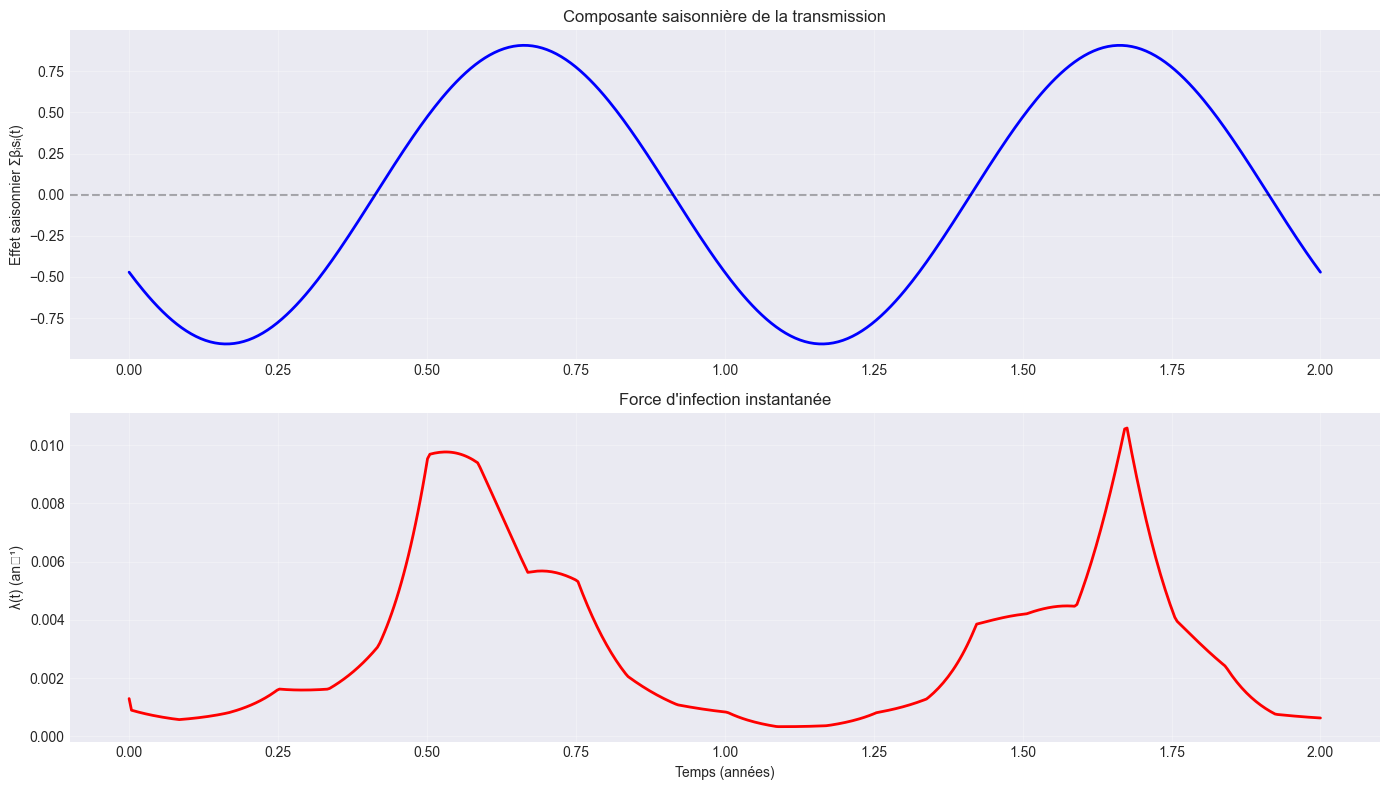

Force d'infection moyenne: 0.0031 an⁻¹
Force d'infection max: 0.0106 an⁻¹
Force d'infection min: 0.0003 an⁻¹


In [5]:
class MalariaIntensities:
    """
    Calcule les intensités du modèle:
    - λ(t): force d'infection instantanée (Eq. 34)
    - μS₁E(t): taux d'infection S₁→E via λₖ(t) (approximation du délai)
    """
    
    def __init__(self, params: MalariaParameters, seasonal_func, climate_func):
        """
        Paramètres:
        -----------
        params : MalariaParameters
            Paramètres du modèle
        seasonal_func : callable
            Fonction s(t) qui retourne Σᵢ βᵢsᵢ(t)
        climate_func : callable
            Fonction Z(t) standardisée
        """
        self.params = params
        self.seasonal_func = seasonal_func
        self.climate_func = climate_func
    
    def compute_lambda_instant(self, state: MalariaState, t: float) -> float:
        """
        Calcule λ(t) = force d'infection instantanée (Eq. 34).
        
        λ(t) = [(I₁ + q·I₂) / P] · β̄ · exp{Σᵢ βᵢsᵢ(t) + Z_t·β}
        
        Cette quantité mesure le risque instantané d'infection par piqûre 
        de moustique infecté.
        
        Paramètres:
        -----------
        state : MalariaState
            État du système
        t : float
            Temps (années)
        
        Retourne:
        ---------
        float : λ(t) en année⁻¹
        """
        # Prévalence pondérée (I₁ compte pleinement, I₂ avec réduction q)
        infectious_fraction = (state.I1 + self.params.q * state.I2) / state.P
        
        # Effet saisonnier (variation annuelle de transmission)
        seasonal_effect = self.seasonal_func(t)
        
        # Effet climatique (précipitations)
        climate_effect = self.climate_func(t) * self.params.beta_climate
        
        # Force d'infection totale
        lambda_t = (infectious_fraction * self.params.beta_bar * 
                   np.exp(seasonal_effect + climate_effect))
        
        return max(lambda_t, 0.0)  # Toujours positif
    
    def compute_mu_S1_E(self, state: MalariaState) -> float:
        """
        Calcule μS₁E(t) = taux d'infection effectif après délai (Eq. 35 simplifiée).
        
        Au lieu de calculer l'intégrale ∫γ(t-s)λ(s)ds, on utilise l'approximation
        via la cascade λ₁ → λ₂ avec k=2 étapes (Éqs. 36-37).
        
        Avec k=2, après la cascade de 2 compartiments λ₁ et λ₂:
        μS₁E(t) ≈ λ₂(t)
        
        Paramètres:
        -----------
        state : MalariaState
            État contenant λ₂(t)
        
        Retourne:
        ---------
        float : μS₁E(t) en année⁻¹
        """
        # Avec la cascade à k=2 étapes, λ₂ représente la force d'infection
        # retardée qui a traversé tout le délai gamma
        return max(state.lambda2, 0.0)

# Implémentation des fonctions auxiliaires (seasonal et climate)
def create_seasonal_function(params: MalariaParameters) -> callable:
    """
    Crée la fonction saisonnière Σᵢ βᵢsᵢ(t).
    Version simplifiée avec des fonctions sinusoïdales.
    """
    def seasonal(t: float) -> float:
        # Approximation: combinaison de sinusoïdes annuelles
        # Les vrais B-splines seraient plus complexes, mais cette approximation
        # capture l'essentiel de la variabilité saisonnière
        t_year = t % 1.0  # Ramène dans [0, 1)
        
        # Harmoniques pour approximer les 6 B-splines
        effect = 0.0
        for i, beta_i in enumerate(params.beta_splines):
            # Chaque spline contribue avec une phase décalée
            phase = 2 * np.pi * i / params.n_s
            effect += beta_i * np.cos(2 * np.pi * t_year - phase)
        
        # Normalisation pour que la moyenne soit ~0
        return effect / params.n_s
    
    return seasonal

def create_climate_function(times: np.ndarray, rainfall: np.ndarray, 
                            params: MalariaParameters) -> callable:
    """
    Crée la fonction de covariate climatique Z(t) standardisée.
    Version simplifiée qui retourne 0 si pas de données disponibles.
    """
    if rainfall is None or len(rainfall) == 0:
        # Pas de données climatiques: effet nul
        return lambda t: 0.0
    
    # Pour l'instant, approximation simple
    # (On pourrait intégrer la pluie sur [t-u, t] comme dans l'article)
    def climate(t: float) -> float:
        # Interpolation linéaire simple
        if t < times[0] or t > times[-1]:
            return 0.0
        
        # Trouve l'index le plus proche
        idx = np.searchsorted(times, t)
        if idx == 0:
            return 0.0
        if idx >= len(times):
            return 0.0
        
        # Interpolation linéaire
        t0, t1 = times[idx-1], times[idx]
        r0, r1 = rainfall[idx-1], rainfall[idx]
        
        weight = (t - t0) / (t1 - t0) if t1 > t0 else 0.0
        rain_t = r0 + weight * (r1 - r0)
        
        # Standardisation approximative (moyenne des données = 0)
        rain_mean = np.mean(rainfall)
        rain_std = np.std(rainfall)
        
        return (rain_t - rain_mean) / rain_std if rain_std > 0 else 0.0
    
    return climate

# Simulation de données de précipitations mensuelles
n_months = 240  # 20 ans
times_months = np.linspace(0, 20, n_months)

# Pluies avec saisonnalité (simulation simplifiée de type mousson)
rainfall_simulated = (
    150 * (1 + 0.5 * np.sin(2 * np.pi * times_months - np.pi/2)) +  # Saisonnalité
    50 * np.random.randn(n_months)  # Variabilité
)
rainfall_simulated = np.maximum(rainfall_simulated, 0)  # Pas de pluie négative

# Test des intensités
seasonal_func = create_seasonal_function(params)
climate_func = create_climate_function(times_months, rainfall_simulated, params)

intensities = MalariaIntensities(params, seasonal_func, climate_func)

# Test sur une année
t_test = np.linspace(0, 2, 500)
lambda_values = []
seasonal_values = []

for t in t_test:
    lambda_t = intensities.compute_lambda_instant(state_initial, t)
    lambda_values.append(lambda_t)
    seasonal_values.append(seasonal_func(t))

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Graphique 1: Effet saisonnier
axes[0].plot(t_test, seasonal_values, 'b-', linewidth=2)
axes[0].set_ylabel('Effet saisonnier Σβᵢsᵢ(t)')
axes[0].set_title('Composante saisonnière de la transmission')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Graphique 2: Force d'infection
axes[1].plot(t_test, lambda_values, 'r-', linewidth=2)
axes[1].set_xlabel('Temps (années)')
axes[1].set_ylabel('λ(t) (an⁻¹)')
axes[1].set_title('Force d\'infection instantanée')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Force d'infection moyenne: {np.mean(lambda_values):.4f} an⁻¹")
print(f"Force d'infection max: {np.max(lambda_values):.4f} an⁻¹")
print(f"Force d'infection min: {np.min(lambda_values):.4f} an⁻¹")

###  Équations d'État (Déterministes)

In [6]:
class MalariaDynamics:
    """
    Implémente les équations d'état du modèle VS²EI² (Éqs. 29-33, 36-37).
    """
    
    def __init__(self, params: MalariaParameters, intensities: MalariaIntensities):
        self.params = params
        self.intensities = intensities
    
    def compute_derivatives(self, state: MalariaState, t: float) -> MalariaState:
        """
        Calcule les dérivées dX/dt pour tous les compartiments.
        
        Ces équations représentent les flux entre compartiments:
        - Naissances dans S₁
        - Infections S₁ → E
        - Progression E → I₁ → I₂
        - Retours vers S₁ et S₂ (guérison, perte immunité)
        - Décès naturels (taux δ constant)
        
        Paramètres:
        -----------
        state : MalariaState
            État actuel
        t : float
            Temps
        
        Retourne:
        ---------
        MalariaState : Dérivées (dS1/dt, dS2/dt, ...)
        """
        p = self.params
        
        # Calcul de la population totale (normalisée à 1)
        P = state.P
        
        # Taux de naissance (interpolation démographique)
        # Pour simplifier, on suppose un taux constant qui maintient P=1
        birth_rate = p.delta  # Naissances = décès pour stabilité
        
        # Force d'infection instantanée et retardée
        lambda_instant = self.intensities.compute_lambda_instant(state, t)
        mu_S1_E = self.intensities.compute_mu_S1_E(state)
        
        # Note: p.mu_S2_I2 devrait dépendre de λ₂, on utilise une approximation
        # Pour simplifier, on suppose mu_S2_I2 = c * mu_S1_E
        mu_S2_I2 = p.c * mu_S1_E
        # ============================================================
        # ÉQUATIONS D'ÉTAT HUMAINES (Éqs. 29-33)
        # ============================================================
        
        # dS₁/dt (Eq. 29): Susceptibles naïfs
        dS1_dt = (
            birth_rate * P                    # Naissances
            - mu_S1_E * state.S1              # Infections S₁ → E
            + p.mu_I1_S1 * state.I1          # Guérisons I₁ → S₁
            + p.mu_S2_S1 * state.S2          # Perte immunité S₂ → S₁
            - p.delta * state.S1              # Décès naturels
        )
        
        # dS₂/dt (Eq. 30): Partiellement protégés
        dS2_dt = (
            p.mu_I2_S2 * state.I2            # Guérisons partielles I₂ → S₂
            - p.mu_S2_S1 * state.S2          # Perte immunité S₂ → S₁
            - mu_S2_I2 * state.S2          # Réinfections S₂ → I₂ (via λ₂ implicite)
            - p.delta * state.S2              # Décès naturels
        )
       
        dS2_dt -= mu_S2_I2 * state.S2
        # dE/dt (Eq. 31): Exposés (infection latente)
        dE_dt = (
            mu_S1_E * state.S1               # Nouvelles infections S₁ → E
            - p.mu_E_I1 * state.E            # Fin latence E → I₁
            - p.delta * state.E               # Décès naturels
        )
        
        # dI₁/dt (Eq. 32): Infectés symptomatiques
        dI1_dt = (
            p.mu_E_I1 * state.E              # Fin latence E → I₁
            - p.mu_I1_S1 * state.I1          # Guérisons I₁ → S₁
            - p.mu_I1_I2 * state.I1          # Passage I₁ → I₂
            - p.delta * state.I1              # Décès naturels
        )
        
        # dI₂/dt (Eq. 33): Infectés asymptomatiques
        dI2_dt = (
            p.mu_I1_I2 * state.I1            # Passage I₁ → I₂
            + mu_S2_I2 * state.S2            # Réinfections S₂ → I₂
            - p.mu_I2_S2 * state.I2          # Guérisons I₂ → S₂
            - p.delta * state.I2              # Décès naturels
        )
        
        # ============================================================
        # CASCADE DE DÉLAI (Éqs. 36-37): λ → λ₁ → λ₂
        # ============================================================
        
        # Cette cascade approxime l'intégrale de convolution avec le noyau gamma.
        # Avec k=2 étapes et délai moyen τ:
        #   - Taux de transition entre étapes: k/τ
        #   - λ₁ reçoit λ(t) et transmet vers λ₂
        #   - λ₂ représente la force d'infection retardée
        
        transition_rate = p.k / p.tau  # = 2/0.03 ≈ 66.7 an⁻¹
        
        # dλ₁/dt (Eq. 36): Première étape du délai
        dlambda1_dt = (lambda_instant - state.lambda1) * transition_rate
        
        # dλ₂/dt (Eq. 37): Deuxième étape (sortie = μS₁E)
        dlambda2_dt = (state.lambda1 - state.lambda2) * transition_rate
        
        # Retourne les dérivées dans une structure MalariaState
        return MalariaState(
            S1=dS1_dt, S2=dS2_dt, E=dE_dt, I1=dI1_dt, I2=dI2_dt,
            lambda1=dlambda1_dt, lambda2=dlambda2_dt, P=0.0  # dP/dt = 0
        )

# Test des dérivées
dynamics = MalariaDynamics(params, intensities)

derivatives = dynamics.compute_derivatives(state_initial, t=0.0)

print("Dérivées à t=0:")
print(f"  dS₁/dt = {derivatives.S1:+.6f} an⁻¹")
print(f"  dS₂/dt = {derivatives.S2:+.6f} an⁻¹")
print(f"  dE/dt = {derivatives.E:+.6f} an⁻¹")
print(f"  dI₁/dt = {derivatives.I1:+.6f} an⁻¹")
print(f"  dI₂/dt = {derivatives.I2:+.6f} an⁻¹")
print(f"  dλ₁/dt = {derivatives.lambda1:+.6f} an⁻¹")
print(f"  dλ₂/dt = {derivatives.lambda2:+.6f} an⁻¹")
print(f"\n Somme compartiments humains: {derivatives.S1 + derivatives.S2 + derivatives.E + derivatives.I1 + derivatives.I2:.6e}")
print("  (Devrait être ≈ 0 car naissances ≈ décès)")

Dérivées à t=0:
  dS₁/dt = +0.288374 an⁻¹
  dS₂/dt = -0.271645 an⁻¹
  dE/dt = -0.034846 an⁻¹
  dI₁/dt = +0.011420 an⁻¹
  dI₂/dt = +0.006669 an⁻¹
  dλ₁/dt = -1.053633 an⁻¹
  dλ₂/dt = +0.733333 an⁻¹

 Somme compartiments humains: -2.727500e-05
  (Devrait être ≈ 0 car naissances ≈ décès)




**Explication du flux entre compartiments**:
```
         Naissances
              ↓
         ┌────S₁────┐  (Susceptibles naïfs)
         │    ↓     ↑
   λ₂(t) │    E     │ (guérison I₁→S₁)
         │    ↓     │
         │    I₁────┤  (Infectés symptomatiques)
         │    ↓     ↓
         └→   I₂    → S₂  (Partiellement protégés)
              ↓          ↑
           Guérison  Perte immunité
```